# SPDE

In this tutorial, we show how to use the API SPDE.

In [28]:
import gstlearn as gl
import gstlearn.plot as gp
import numpy as np
import matplotlib.pyplot as plt

from sksparse.cholmod import cholesky
import scipy as sc
from scipy.sparse import *
from scipy.sparse.linalg import *
import numpy as np


dat = gl.Db.create()
ndat = 1000
rangev = 0.2
sill = 1.
nugget = 0.1

np.random.seed(123)
dat["x"] = np.random.uniform(size=ndat)
dat["y"] = np.random.uniform(size=ndat)
dat.setLocators(["x","y"],gl.ELoc.X)

grid = gl.DbGrid.create([50,50],[0.02,0.02],[0,0])
gridExt = gl.DbGrid.create([75,75],[0.02,0.02],[-0.25,-0.25])
mesh = gl.MeshETurbo(gridExt)
model = gl.Model.createFromParam(gl.ECov.BESSEL_K,param=1,range=rangev,sill=sill)
model.addCovFromParam(gl.ECov.NUGGET,sill=nugget)

spde = gl.SPDE()
spde.init(model,grid,None,gl.ESPDECalcMode.SIMUNONCOND)




In [29]:
spde.compute()
spde.query(dat)
spde.query(grid)

3

<AxesSubplot:title={'center':'spde.simu'}>

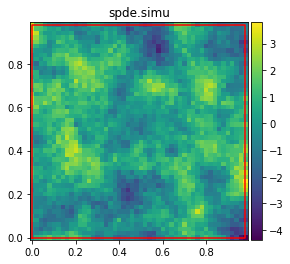

In [30]:
gp.grid(grid)

In [31]:
spdeRes = gl.SPDE()
spdeRes.init(model,grid,dat,gl.ESPDECalcMode.KRIGING,mesh)
spdeRes.compute()

In [32]:
Qtr = gl.csToTriplet(spdeRes.getPrecisionOp().getQ())
Pgl = gl.ProjMatrix(dat,mesh)
Apgl = Pgl.getAproj()
Atr = gl.csToTriplet(Apgl)
Q = sc.sparse.csc_matrix((np.array(Qtr.values), (np.array(Qtr.rows), np.array(Qtr.cols))))
Aproj = sc.sparse.csc_matrix((np.array(Atr.values), (np.array(Atr.rows), np.array(Atr.cols))),
                         shape=(Atr.nrows,Atr.ncols))

cholQ=cholesky(Q)
u = np.random.normal(size = Q.shape[0])
b = Q @ u
print(np.max(np.abs(cholQ.solve_A(b) - u)))


Qop = Q + 1/nugget * Aproj.T @ Aproj
cholQop =  cholesky(Qop)

2.402522625288839e-13


In [33]:
def solveMat(cholQop,x):
    return cholQop.solve_A(x)

def invSigma(sigma2,Aproj,cholQop,x):
    return 1./sigma2 * (x - 1./sigma2 * Aproj @ solveMat(cholQop, Aproj.T @ x))

def detQ(cholQ):
    return cholQ.logdet()

x = dat["spde.simu"]
ones = np.ones_like(x)
invSigmaOnes = invSigma(nugget,Aproj,cholQop,ones)
mu  = np.sum(x * invSigmaOnes)/np.sum( ones * invSigmaOnes) 
quad = np.sum((x-mu)*invSigma(nugget,Aproj,cholQop,x-mu))
logdet = len(x) * np.log(nugget) - detQ(cholQ) + detQ(cholQop)

print("logdet_chol",logdet)
print("quad_chol",quad)
print("like_chol",-0.5 * (quad + logdet))

logdet_chol -1253.0487780470085
quad_chol 1099.700931923758
like_chol 76.67392306162526


In [34]:
pcm = spdeRes.getPrecisionKriging()
a = pcm.computeLogDetOp(1,0)
b = detQ(cholQop)
print(a)
print(b)
print((b-a)/a)

12511.318295264231
12634.973927613199
0.009883501436916813


In [35]:
a = detQ(cholQ)
b = pcm.computeLogDetQ(10,0)
print(a)
print(b)
print((b-a)/a)

11585.437612666161
11348.081876507305
-0.020487420854897923


In [36]:
a = spdeRes.computeLogLike(10,0)
b = -0.5 * (quad + logdet)
print(a)
print(b)
print((b-a)/b)

-95.55169894587038
76.67392306162526
2.24620855605722


In [37]:
pm = spdeRes.getPrecisionKriging()
x =[np.random.uniform(size=mesh.getNApices())]
y =gl.VectorVectorDouble(1)
y[0] = gl.VectorDouble(mesh.getNApices())
z =gl.VectorVectorDouble(1)
z[0] = gl.VectorDouble(mesh.getNApices())
pm.evalDirect(x,y)
pm.evalInverse(y,z)
np.max(x[0]-z[0])

0.0001382161342629029

<Figure size 432x288 with 0 Axes>

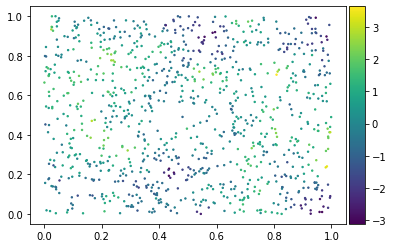

In [38]:
fig = plt.figure()
gp.plot(dat,size=2)


In [12]:
dat


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 3
Maximum Number of UIDs       = 3
Total number of samples      = 1000

Variables
---------
Column = 0 - Name = x - Locator = x1
Column = 1 - Name = y - Locator = x2
Column = 2 - Name = spde.simu - Locator = z1

In [13]:
spdeRes = gl.SPDE()
spdeRes.init(model,grid,dat,gl.ESPDECalcMode.KRIGING,mesh)
spdeRes.compute()
spdeRes.query(grid)
spdeRes.computeQuad()

1100.48176782241

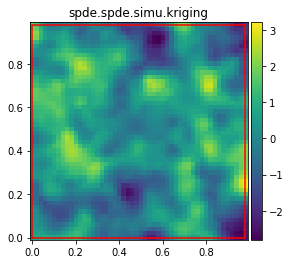

In [14]:
gp.plot(grid)

In [23]:
from scipy.optimize import minimize
mesh = gl.MeshETurbo(gridExt)
class storage :
    def __init__(self):
        pass
            
    def f(self,x) :
        print(x**2)
        self.model = gl.Model.createFromParam(gl.ECov.BESSEL_K,param=1,
                                              range=x[0]**2,
                                              sill=x[1]**2)
        self.model.addCovFromParam(gl.ECov.NUGGET,sill=x[2]**2)
        self.spde = gl.SPDE()
        self.spde.init(self.model,grid,dat,gl.ESPDECalcMode.KRIGING,mesh)
        self.spde.compute()
        res = -self.spde.computeLogLike(10,12134)
        print(res)
        return res
    
    def fchol(self,x):
        self.model = gl.Model.createFromParam(gl.ECov.BESSEL_K,param=1,
                                              range=x[0]**2,
                                              sill=x[1]**2)
        self.model.addCovFromParam(gl.ECov.NUGGET,sill=x[2]**2)
        self.spde = gl.SPDE()
        self.spde.init(self.model,grid,dat,gl.ESPDECalcMode.KRIGING,mesh)
        self.spde.compute()
        Qtr = gl.csToTriplet(self.spde.getPrecisionOp().getQ())
        Pgl = gl.ProjMatrix(dat,mesh)
        Apgl = Pgl.getAproj()
        Atr = gl.csToTriplet(Apgl)
        Q = sc.sparse.csc_matrix((np.array(Qtr.values), (np.array(Qtr.rows), np.array(Qtr.cols))))
        Aproj = sc.sparse.csc_matrix((np.array(Atr.values), (np.array(Atr.rows), np.array(Atr.cols))),
                         shape=(Atr.nrows,Atr.ncols))
        cholQ=cholesky(Q)
        Qop = Q + 1/nugget * Aproj.T @ Aproj
        cholQop =  cholesky(Qop)
        x = dat["spde.simu"]
        ones = np.ones_like(x)
        invSigmaOnes = invSigma(nugget,Aproj,cholQop,ones)
        mu  = np.sum(x * invSigmaOnes)/np.sum( ones * invSigmaOnes) 
        quad = np.sum((x-mu)*invSigma(nugget,Aproj,cholQop,x-mu))
        logdet = len(x) * np.log(nugget) - detQ(cholQ) + detQ(cholQop)
        ones = np.ones_like(x)
        invSigmaOnes = invSigma(nugget,Aproj,cholQop,ones)
        mu  = np.sum(x * invSigmaOnes)/np.sum( ones * invSigmaOnes) 
        quad = np.sum((x-mu)*invSigma(nugget,Aproj,cholQop,x-mu))
        logdet = len(x) * np.log(nugget) - detQ(cholQ) + detQ(cholQop)
        return  0.5 * (logdet + quad)

In [24]:
A = storage()
trueParams = np.array([np.sqrt(rangev),np.sqrt(sill),np.sqrt(nugget)])
print(trueParams**2)
A.f(trueParams)


[0.2 1.  0.1]
[0.2 1.  0.1]
-103.54697931250132


-103.54697931250132

In [25]:
def cb(xk):
    print("-----------------------------------------------------")
    print(xk**2)
    
    
#paramsInit = np.sqrt([0.5,0.5,0.5])
#res = minimize(A.f, paramsInit,callback=cb,method="BFGS")


In [26]:
trueParams

u = np.linspace(np.sqrt(0.5),np.sqrt(1.5),20)
res = [A.f(np.array([trueParams[0],i,trueParams[2]])) for i in u]
res2 = [A.fchol(np.array([trueParams[0],i,trueParams[2]])) for i in u]


[0.2 0.5 0.1]
-52.45149336519694
[0.2        0.53927123 0.1       ]
-65.8090418934878
[0.2        0.58002695 0.1       ]
-77.64419595583456
[0.2        0.62226714 0.1       ]
-88.12468496473014
[0.2        0.66599182 0.1       ]
-97.30720483673485
[0.2        0.71120099 0.1       ]
-105.32327006986861
[0.2        0.75789463 0.1       ]
-112.37253685769781
[0.2        0.80607276 0.1       ]
-118.46845300433813
[0.2        0.85573538 0.1       ]
-123.78117701607891
[0.2        0.90688247 0.1       ]
-127.9914133672944
[0.2        0.95951405 0.1       ]
-129.9676604778814
[0.2        1.01363011 0.1       ]
-128.98481877013012
[0.2        1.06923066 0.1       ]
-135.4683683931445
[0.2        1.12631569 0.1       ]
-137.06679900574932
[0.2       1.1848852 0.1      ]
-137.7013025016846
[0.2        1.24493919 0.1       ]
-137.64171968268607
[0.2        1.30647767 0.1       ]
-137.3276120631022
[0.2        1.36950063 0.1       ]
-136.54684136651076
[0.2        1.43400807 0.1       ]
-135.58266

1.1263156869539404
1.1848851981435498


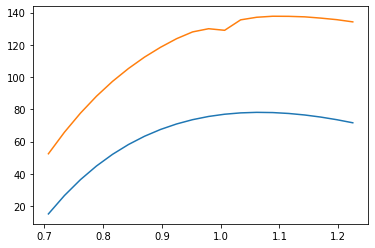

In [27]:
ax=plt.plot(u,-np.array(res2))
ax=plt.plot(u,-np.array(res))

#plt.vlines(1,-400,500)
print(u[np.argmin(res2)]**2)
print(u[np.argmin(res)]**2)

In [ ]:
# Vraisemblance 2D dans les 2 cas
